This script calculates the overall fragility in some statistical areas of the municipality of Bologna considering these indicators:
- demographic fragility
- economic fragility
- social fragility
- climate fragility

### 0. Libraries

In [2]:
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 74.5 MB/s eta 0:00:00


In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import contextily as cx
import re
import matplotlib as mpl

### 1. Overall fragility

In [5]:
# Read the csv of fragility map
df = pd.read_csv(r"/data/Climate Shelter_Talea/Fragility/indici-di-fragilita-dal-2021.csv", sep=';')

In [ ]:
df.head()

,Area statistica,Flag Area Esclusa,Popolazione residente,Variazione popolazione ultimi 5 anni,Tasso incremento demografico medio,Perc residenti oltre 80 anni,% residenti oltre 65 anni che vive sola,% ricambio popolaz. italiana tra 20 e 64 anni,% ricambio popolaz. straniera tra 20 e 64 anni,% stranieri 0 - 19 anni,...,Indice potenziale fragilità economica,Indice complessivo fragilità,Gruppo,Anno,Cod Area Statistica,INTEGRAZIONE,SPAZINSUFF,BIL,BQE,zona di prossimità
0,Borgo Centro,0,7934,0.9,-3.3,9.4,31.2,7.2,5.2,31.8,...,98.0,101.0,4,2021,8,94.7,2.6,96.5,107.2,BORGO PANIGALE
1,Triumvirato-Pietra,0,5279,3.2,-1.9,9.7,28.3,7.5,4.1,23.9,...,98.0,99.0,4,2021,9,96.6,2.5,92.8,107.2,CASTELDEBOLE - PONTELUNGO
2,Caserme Rosse-Manifattura,0,2141,1.0,-13.9,10.1,26.7,5.6,4.5,29.3,...,107.0,106.0,1,2021,12,97.1,1.6,101.9,99.9,CORTICELLA - DOZZA
3,Via Ferrarese,0,11696,4.3,1.2,6.9,32.8,9.5,6.5,39.9,...,107.0,101.0,1,2021,15,94.3,2.8,108.3,101.0,BOLOGNINA
4,Ex Mercato Ortofrutticolo,0,1256,52.8,5.8,3.1,26.4,9.9,14.6,64.9,...,99.0,94.0,1,2021,16,94.4,1.4,140.6,112.9,BOLOGNINA


In [6]:
df.columns

Index(['Area statistica', 'Flag Area Esclusa', 'Popolazione residente',
       'Variazione popolazione ultimi 5 anni',
       'Tasso incremento demografico medio', 'Perc residenti oltre 80 anni',
       '% residenti oltre 65 anni che vive sola',
       '% ricambio popolaz. italiana tra 20 e 64 anni',
       '% ricambio popolaz. straniera tra 20 e 64 anni',
       '% stranieri 0 - 19 anni',
       '% minori in famiglie monogenitoriali sul totale minori',
       '% laureati sul totale da 25-44 anni', '% abitazioni non occupate',
       '% anziani in alta fragilità sanitaria',
       '% abitazioni occupate in affitto',
       'Reddito pro capite mediano delle famiglie',
       '% famiglio con reddito <13k',
       'Indice potenziale fragilità demografica',
       'Indice potenziale fragilità sociale',
       'Indice potenziale fragilità economica', 'Indice complessivo fragilità',
       'Gruppo', 'Anno', 'Cod Area Statistica', 'INTEGRAZIONE', 'SPAZINSUFF',
       'BIL', 'BQE', 'zona di pr

In [7]:
# Select only desired columns
selected_columns = ['Indice potenziale fragilità demografica',
       'Indice potenziale fragilità sociale',
       'Indice potenziale fragilità economica',
       'Indice complessivo fragilità', 'Gruppo',
       'Cod Area Statistica']

# keep desired columns
df_selected= df[selected_columns]
df_selected.head()

,Indice potenziale fragilità demografica,Indice potenziale fragilità sociale,Indice potenziale fragilità economica,Indice complessivo fragilità,Gruppo,Cod Area Statistica
0,100.0,103.0,98.0,101.0,4,8
1,99.0,101.0,98.0,99.0,4,9
2,108.0,102.0,107.0,106.0,1,12
3,92.0,103.0,107.0,101.0,1,15
4,73.0,107.0,99.0,94.0,1,16


In [8]:
# Statistical area wit Gruppo=0 are excluded so we do not consider these areas
# Exclude rows where the column "Gruppo" is equal to 0
df_selected = df_selected[df_selected['Gruppo'] != 0]

In [9]:
# Read shapefile with climate fragility index
#climate_frag = gpd.read_file("D:/Climatic_fragility/climate_fragility_index.shp") #airtemp
climate_frag = gpd.read_file("/data/Climate Shelter_Talea/climate-shelters_2025/data/indicators/climate_fragility_index_lst.shp")

In [10]:
# Rename the column
climate_frag.rename(columns={'codice_are': 'cod_area'}, inplace=True)
climate_frag.head(2)

,cod_area,area_stati,cod_quar,quartiere,cod_zona,zona,green%,blue%,CS,CSI_avg,hot_area%,cold_area%,fragility,Nfragility,geometry
0,9,TRIUMVIRATO-PIETRA,11,Borgo Panigale - Reno,C,Borgo Panigale,0.641065,0.025156,16,0.116757,0.147687,0.174915,0.189794,0.446347,"POLYGON ((11.29699 44.51663, 11.2974 44.51652,..."
1,11,CASTELDEBOLE,11,Borgo Panigale - Reno,C,Borgo Panigale,0.577847,0.042175,19,0.091588,0.041363,0.211648,0.118105,0.415477,"POLYGON ((11.28826 44.50371, 11.28808 44.50357..."


In [11]:
# Rename the column in the CSV file to match the column in the shapefile
df_selected.rename(columns={'Cod Area Statistica': 'cod_area'}, inplace=True)

In [12]:
df_selected['cod_area'] = df_selected['cod_area'].astype(str)  # Convert 'cod_area' to string type
climate_frag['cod_area'] = climate_frag['cod_area'].astype(str)  # Convert 'cod_area' to string type

In [13]:
# Merge the shapefile with the CSV file based on the common column
merged_data = climate_frag.merge(df_selected, left_on='cod_area', right_on='cod_area', how='inner')

In [14]:
merged_data.head(2)

,cod_area,area_stati,cod_quar,quartiere,cod_zona,zona,green%,blue%,CS,CSI_avg,hot_area%,cold_area%,fragility,Nfragility,geometry,Indice potenziale fragilità demografica,Indice potenziale fragilità sociale,Indice potenziale fragilità economica,Indice complessivo fragilità,Gruppo
0,9,TRIUMVIRATO-PIETRA,11,Borgo Panigale - Reno,C,Borgo Panigale,0.641065,0.025156,16,0.116757,0.147687,0.174915,0.189794,0.446347,"POLYGON ((11.29699 44.51663, 11.2974 44.51652,...",99.0,101.0,98.0,99.0,4
1,11,CASTELDEBOLE,11,Borgo Panigale - Reno,C,Borgo Panigale,0.577847,0.042175,19,0.091588,0.041363,0.211648,0.118105,0.415477,"POLYGON ((11.28826 44.50371, 11.28808 44.50357...",103.0,101.0,93.0,99.0,4


In [15]:
# Rename columns
merged_data.rename(columns={'fragility':'f_clim', 'Nfragility': 'N_f_clim',
                            'Indice potenziale fragilità demografica': 'f_dem',
                            'Indice potenziale fragilità sociale': 'f_soc',
                            'Indice potenziale fragilità economica': 'f_eco',
                            'Indice complessivo fragilità': 'fragility1'
                            }, inplace=True)

In [16]:
# Normalize demographic, economic, social and overall fragility

# Identify min and max value of f_dem
min_value_dem = merged_data['f_dem'].min()
max_value_dem = merged_data['f_dem'].max()
# Normalization
merged_data['N_f_dem']= (merged_data['f_dem'] - min_value_dem) / (max_value_dem - min_value_dem)

# Identify min and max value of f_soc
min_value_soc = merged_data['f_soc'].min()
max_value_soc = merged_data['f_soc'].max()
# Normalization
merged_data['N_f_soc']= (merged_data['f_soc'] - min_value_soc) / (max_value_soc - min_value_soc)

# Identify min and max value of f_eco
min_value_eco = merged_data['f_eco'].min()
max_value_eco = merged_data['f_eco'].max()
# Normalization
merged_data['N_f_eco']= (merged_data['f_eco'] - min_value_eco) / (max_value_eco - min_value_eco)

# Identify min and max value of fragility1
min_value_f1 = merged_data['fragility1'].min()
max_value_f1 = merged_data['fragility1'].max()
# Normalization
merged_data['N_frag1']= (merged_data['fragility1'] - min_value_f1) / (max_value_f1 - min_value_f1)


In [17]:
# Calculation of the new indicator of potential fragility by a weighted average of the 4 indicators
weight_eco = 2.25
weight_dem = 2.25
weight_clim = 2.25
weight_soc = 3.25

total_weight = weight_eco + weight_dem + weight_clim + weight_soc

merged_data['N_frag2'] = (merged_data['N_f_eco']*weight_eco + merged_data['N_f_dem']*weight_dem +
                          merged_data['N_f_clim']*weight_clim + merged_data['N_f_soc']*weight_soc)/total_weight


In [18]:
merged_data.head()

,cod_area,area_stati,cod_quar,quartiere,cod_zona,zona,green%,blue%,CS,CSI_avg,...,f_dem,f_soc,f_eco,fragility1,Gruppo,N_f_dem,N_f_soc,N_f_eco,N_frag1,N_frag2
0,9,TRIUMVIRATO-PIETRA,11,Borgo Panigale - Reno,C,Borgo Panigale,0.641065,0.025156,16,0.116757,...,99.0,101.0,98.0,99.0,4,0.634146,0.500000,0.340909,0.421053,0.482316
1,11,CASTELDEBOLE,11,Borgo Panigale - Reno,C,Borgo Panigale,0.577847,0.042175,19,0.091588,...,103.0,101.0,93.0,99.0,4,0.731707,0.500000,0.227273,0.421053,0.471753
2,37,BATTINDARNO,11,Borgo Panigale - Reno,A,Barca,0.543864,0.000000,28,0.068966,...,107.0,101.0,95.0,101.0,4,0.829268,0.500000,0.272727,0.526316,0.543228
3,56,MEZZOFANTI,15,Santo Stefano,O,Murri,0.462084,0.000000,4,0.051822,...,100.0,92.0,92.0,94.0,5,0.658537,0.125000,0.204545,0.157895,0.367254
4,26,PESCAROLA,12,Navile,I,Lame,0.684043,0.000000,15,0.071615,...,99.0,102.0,107.0,103.0,4,0.634146,0.541667,0.545455,0.631579,0.541714


In [20]:
# Save shapefile
#merged_data.to_file("/data/Fragility/new_fragility.shp") #airtemp
merged_data.to_file("/data/indicators/new_fragility_lst.shp") #lst data

### 2. Analysis fragility

In [27]:
df = gpd.read_file("/data/Fragility/new_fragility_classi.shp")
#df = gpd.read_file("/data/indicators/new_fragility_lst.shp")

In [28]:
df.shape

(59, 27)

In [29]:
df.head(2)

,cod_area,area_stati,cod_quar,quartiere,cod_zona,zona,green_,blue_,CS,CSI_avg,...,fragility1,Gruppo,N_f_dem,N_f_soc,N_f_eco,N_frag1,N_frag2,c_frag1,c_frag2,geometry
0,9,TRIUMVIRATO-PIETRA,11,Borgo Panigale - Reno,C,Borgo Panigale,0.641065,0.025156,16.0,0.116757,...,99.0,4.0,0.634146,0.5,0.340909,0.421053,0.510143,"(0.4,0.6]","(0.4,0.6]","POLYGON ((11.29699 44.51663, 11.2974 44.51652,..."
1,11,CASTELDEBOLE,11,Borgo Panigale - Reno,C,Borgo Panigale,0.577847,0.042175,19.0,0.091588,...,99.0,4.0,0.731707,0.5,0.227273,0.421053,0.507975,"(0.4,0.6]","(0.4,0.6]","POLYGON ((11.28826 44.50371, 11.28808 44.50357..."


In [30]:
import re
nomi = []

for index, row in df.iterrows():
    area = row['area_stati']
    frag1 = row['c_frag1']
    frag2 = row['c_frag2']


    # Estrai i numeri dai formati degli intervalli
    frag1_values = re.findall(r'\d+\.\d+', frag1)
    frag2_values = re.findall(r'\d+\.\d+', frag2)

    # Converte i valori in float per il confronto
    frag1_min = float(frag1_values[0])
    frag2_min = float(frag2_values[0])

    # Verifica se frag1 è minore di frag2, se sono uguali o se frag1 è maggiore di frag2
    if frag1_min < frag2_min:
        print(f"The statistical area {area} has overall fragility {frag1} smaller than new overall fragility {frag2}")
        nomi.append(area)

    #if frag1_min == frag2_min:
     #   print(f"The statistical area {area} has overall fragility {frag1} equal to new overall fragility {frag2}")

    #if frag1_min > frag2_min:
     #   print(f"The statistical area {area} has overall fragility {frag1} greater than new overall fragility {frag2}")
        #nomi.append(area)


The statistical area MALPIGHI-1 has overall fragility (0.2,0.4] smaller than new overall fragility (0.4,0.6]
The statistical area STADIO-MELONCELLO has overall fragility (0.2,0.4] smaller than new overall fragility (0.4,0.6]
The statistical area EMILIA PONENTE has overall fragility (0.2,0.4] smaller than new overall fragility (0.4,0.6]
The statistical area MENGOLI has overall fragility (0.2,0.4] smaller than new overall fragility (0.4,0.6]
The statistical area FOSSOLO has overall fragility (0.2,0.4] smaller than new overall fragility (0.4,0.6]
The statistical area GALVANI-1 has overall fragility (0.2,0.4] smaller than new overall fragility (0.4,0.6]
The statistical area LAZZARETTO has overall fragility (0,0.2] smaller than new overall fragility (0.4,0.6]
The statistical area CANALE DI RENO has overall fragility (0.2,0.4] smaller than new overall fragility (0.4,0.6]
The statistical area IRNERIO-1 has overall fragility (0.2,0.4] smaller than new overall fragility (0.4,0.6]
The statistica

In [31]:
print(', '.join(nomi))

MALPIGHI-1, STADIO-MELONCELLO, EMILIA PONENTE, MENGOLI, FOSSOLO, GALVANI-1, LAZZARETTO, CANALE DI RENO, IRNERIO-1, MARCONI-2, DAGNINI, CHIESANUOVA, EX MERCATO ORTOFRUTTICOLO, SCANDELLARA, VIA LARGA, MARCONI-1, LA NOCE


In [32]:
len(nomi)

17

In [33]:
for index, row in df.iterrows():
    print(f"The statistical area {row['area_stati']} had an overall fragility between {(row['N_frag1'])} and a new overall fragility between {(row['N_frag2'])}")

The statistical area TRIUMVIRATO-PIETRA had an overall fragility between 0.421052631578947 and a new overall fragility between 0.510143096571406
The statistical area CASTELDEBOLE had an overall fragility between 0.421052631578947 and a new overall fragility between 0.507974801321496
The statistical area BATTINDARNO had an overall fragility between 0.526315789473684 and a new overall fragility between 0.566791227296304
The statistical area MEZZOFANTI had an overall fragility between 0.157894736842105 and a new overall fragility between 0.347090531038159
The statistical area PESCAROLA had an overall fragility between 0.631578947368421 and a new overall fragility between 0.561708023092515
The statistical area BEVERARA had an overall fragility between 0.631578947368421 and a new overall fragility between 0.612852458984479
The statistical area MALPIGHI-1 had an overall fragility between 0.368421052631579 and a new overall fragility between 0.50096175680999
The statistical area STADIO-MELONC

In [34]:

import re
nomi = []

for index, row in df.iterrows():
    area = row['area_stati']
    frag1 = row['c_frag1']
    frag2 = row['c_frag2']
    Nfrag1 = row['N_frag1']
    Nfrag2 = row['N_frag2']

    # Estrai i numeri dai formati degli intervalli
    frag1_values = re.findall(r'\d+\.\d+', frag1)
    frag2_values = re.findall(r'\d+\.\d+', frag2)

    # Converte i valori in float per il confronto
    frag1_min = float(frag1_values[-1])
    frag2_min = float(frag2_values[-1])

    N_frag1 = float(Nfrag1)
    N_frag2 = float(Nfrag2)

    # Verifica se frag1 è minore di frag2, se sono uguali o se frag1 è maggiore di frag2
    #if frag1_min == frag2_min:
     # print(f"The statistical area {area} has overall fragility {frag1} equal to new overall fragility {frag2}")
      #nomi.append(area)

      #if N_frag1 < N_frag2:
       # nomi.append(area)
        #print(f"The statistical area {area} has overall fragility {N_frag1} smaller than new overall fragility {N_frag2}")



    if Nfrag2 < Nfrag1:
        print(f"The statistical area {area} has new overall fragility {Nfrag2} smaller than overall fragility {Nfrag1}")
        nomi.append(area)

The statistical area PESCAROLA has new overall fragility 0.561708023092515 smaller than overall fragility 0.631578947368421
The statistical area BEVERARA has new overall fragility 0.612852458984479 smaller than overall fragility 0.631578947368421
The statistical area CASERME ROSSE-MANIFATTURA has new overall fragility 0.625044275130854 smaller than overall fragility 0.789473684210526
The statistical area PIAZZA DELL'UNITA' has new overall fragility 0.706602799079971 smaller than overall fragility 0.842105263157895
The statistical area VIA DEL LAVORO has new overall fragility 0.634575379339427 smaller than overall fragility 0.684210526315789
The statistical area MULINO DEL GOMITO has new overall fragility 0.811281909414566 smaller than overall fragility 1.0
The statistical area VILLAGGIO DELLA BARCA has new overall fragility 0.654168898075136 smaller than overall fragility 0.842105263157895
The statistical area CIRENAICA has new overall fragility 0.61221755948553 smaller than overall fr

In [35]:
print(', '.join(nomi))

PESCAROLA, BEVERARA, CASERME ROSSE-MANIFATTURA, PIAZZA DELL'UNITA', VIA DEL LAVORO, MULINO DEL GOMITO, VILLAGGIO DELLA BARCA, CIRENAICA, VIA MONDO, ZANARDI, SAN DONNINO, TIRO A SEGNO, CAVEDONE


In [36]:
len(nomi)

13

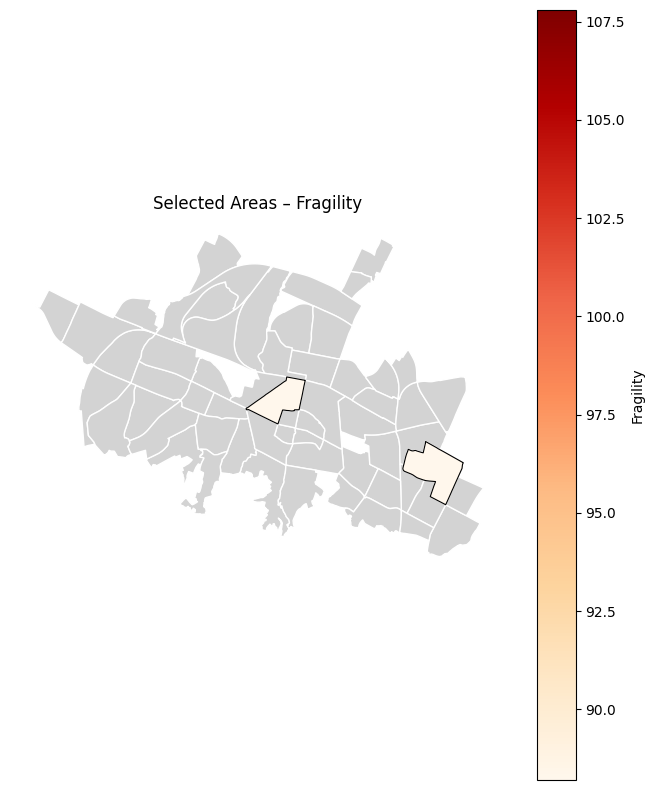

In [38]:
# Load data
gdf = gpd.read_file("/data/Fragility/new_fragility_classi.shp")

# Filter for selected areas (or skip this to show the full map)
selected = gdf[gdf['area_stati'].isin(['FOSSOLO', 'MARCONI-2'])]

# Plot all areas with grey boundaries
fig, ax = plt.subplots(figsize=(8, 10))
gdf.plot(ax=ax, color='lightgrey', edgecolor='white')

# Plot selected areas colored by fragility
selected.plot(
    ax=ax,
    column='fragility1',
    cmap='OrRd',
    linewidth=0.8,
    edgecolor='black',
    legend=True,
    legend_kwds={'label': "Fragility"}
)

ax.set_title("Selected Areas – Fragility")
plt.axis('off')
plt.show()


In [39]:
check = gdf[gdf['area_stati'].isin(['FOSSOLO', 'MARCONI-2'])]
print(check[['area_stati', 'fragility1', 'N_frag1', 'N_frag2', 'c_frag1', 'c_frag2']])



   area_stati  fragility1   N_frag1   N_frag2    c_frag1    c_frag2
19    FOSSOLO        98.0  0.368421  0.433599  (0.2,0.4]  (0.4,0.6]
39  MARCONI-2        98.0  0.368421  0.536080  (0.2,0.4]  (0.4,0.6]


The statistical area FOSSOLO has overall fragility (0.2,0.4] smaller than new overall fragility (0.4,0.6].
The statistical area MARCONI-2 has overall fragility (0.2,0.4] smaller than new overall fragility (0.4,0.6].


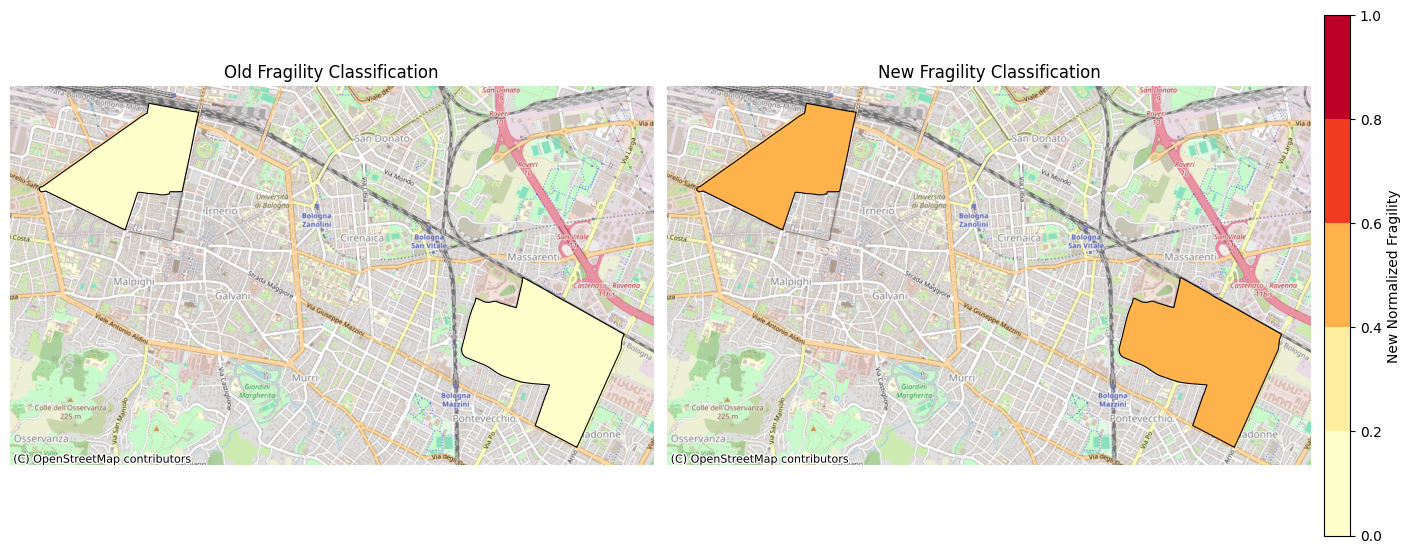

In [40]:

# Load shapefile
gdf = gpd.read_file("/data/Fragility/new_fragility_classi.shp")

# Filter two selected areas
selected = gdf[gdf['area_stati'].isin(['FOSSOLO', 'MARCONI-2'])].copy()

# Define bins and colormap (used in both maps)
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
colors = ['#ffffcc', '#ffeda0', '#feb24c', '#f03b20', '#bd0026']
cmap = ListedColormap(colors)
norm = BoundaryNorm(bins, len(colors))

# Classify fragility bin from N_frag2
def classify_bin(value):
    if value <= 0.2:
        return "(0.0,0.2]"
    elif value <= 0.4:
        return "(0.2,0.4]"
    elif value <= 0.6:
        return "(0.4,0.6]"
    elif value <= 0.8:
        return "(0.6,0.8]"
    else:
        return "(0.8,1.0]"

# Add bin for new fragility based on N_frag2
selected['frag_bin'] = selected['N_frag2'].apply(classify_bin)

# Print interpretation like in the paper
for _, row in selected.iterrows():
    area = row['area_stati']
    old_bin = row['c_frag1']
    new_bin = row['frag_bin']
    print(f"The statistical area {area} has overall fragility {old_bin} smaller than new overall fragility {new_bin}.")

# Reproject for basemap
selected = selected.to_crs(epsg=3857)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 8), constrained_layout=True)


# OLD fragility (c_frag1)
selected.plot(
    ax=axes[0],
    column='c_frag1',
    cmap=cmap,
    linewidth=0.8,
    edgecolor='black',
    legend=False
)
axes[0].set_title("Old Fragility Classification")
cx.add_basemap(axes[0], source=cx.providers.OpenStreetMap.Mapnik)
axes[0].axis('off')

# # NEW fragility (N_frag2)
# selected.plot(
#     ax=axes[1],
#     column='N_frag2',
#     cmap=cmap,
#     norm=norm,
#     linewidth=0.8,
#     edgecolor='black',
#     legend=True,
#     legend_kwds={
#         'label': "New Normalized Fragility",
#         'shrink': 0.6,
#         'ticks': bins
#     }
# )
# Plot without built-in legend
newmap = selected.plot(
    ax=axes[1],
    column='N_frag2',
    cmap=cmap,
    norm=norm,
    linewidth=0.8,
    edgecolor='black',
    legend=False
)

# Add manual colorbar
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # Dummy array for colorbar
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label("New Normalized Fragility")
cbar.set_ticks(bins)
axes[1].set_title("New Fragility Classification")
cx.add_basemap(axes[1], source=cx.providers.OpenStreetMap.Mapnik)
axes[1].axis('off')

#plt.tight_layout()
plt.show()

